In [1]:
import platform
import psutil

# CPU Info
def get_cpu_info():
    cpu_name = platform.processor()
    cpu_cores = psutil.cpu_count(logical=False)
    cpu_threads = psutil.cpu_count(logical=True)
    return cpu_name, cpu_cores, cpu_threads

# RAM Info
def get_ram_info():
    ram = psutil.virtual_memory().total / (1024 ** 3)  # Convert from bytes to GB
    return round(ram, 2)

# GPU Info (requires 'GPUtil' library)
def get_gpu_info():
    try:
        import GPUtil
        gpus = GPUtil.getGPUs()
        if not gpus:
            return "No GPU detected"
        return [(gpu.name, f"{gpu.memoryTotal}MB") for gpu in gpus]
    except ImportError:
        return "GPUtil not installed. Install via 'pip install gputil'"

# Print System Info
cpu_name, cores, threads = get_cpu_info()
print(f"CPU: {cpu_name}")
print(f"Cores: {cores}, Threads: {threads}")
print(f"RAM: {get_ram_info()} GB")
print(f"GPU(s): {get_gpu_info()}")


CPU: x86_64
Cores: 64, Threads: 64
RAM: 502.44 GB
GPU(s): [('NVIDIA A100-SXM4-40GB', '40960.0MB')]


In [2]:
import os

print("===== SLURM Allocation Information =====")

# Number of CPU cores allocated
cpus = os.getenv("SLURM_CPUS_ON_NODE", "Unknown")
print(f"Allocated CPU cores: {cpus}")

# Total memory allocated per node (in MB)
mem_mb = os.getenv("SLURM_MEM_PER_NODE", "Unknown")
print(f"Allocated Memory per node (MB): {mem_mb}")

# Number of GPUs allocated
gpus = os.getenv("SLURM_GPUS_ON_NODE", "Unknown")
print(f"Allocated GPUs: {gpus}")

# GPU resource string (alternative format, if available)
gres = os.getenv("SLURM_JOB_GPUS", "Unknown")
print(f"Allocated GPU IDs: {gres}")

# Total tasks allocated
tasks = os.getenv("SLURM_NTASKS", "Unknown")
print(f"Total Tasks Allocated: {tasks}")

# Number of nodes
nodes = os.getenv("SLURM_JOB_NUM_NODES", "Unknown")
print(f"Total Nodes Allocated: {nodes}")

print("=========================================")


===== SLURM Allocation Information =====
Allocated CPU cores: 16
Allocated Memory per node (MB): 102400
Allocated GPUs: 1
Allocated GPU IDs: 1
Total Tasks Allocated: Unknown
Total Nodes Allocated: 1


In [3]:
!pip install huggingface-hub==0.24.7 llama-cpp-python==0.3.1

^C
ERROR: Operation cancelled by user


In [4]:
!nvidia-smi

Tue Jun 24 14:12:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:81:00.0 Off |                    0 |
| N/A   36C    P0             51W /  400W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [6]:
!pip install llama-cpp-python


The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.
^C
ERROR: Operation cancelled by user


In [15]:
import re
import torch
import pandas as pd
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_PATH = "/project/ai901501-ai0001/menth/models/THaLLE-0.1-7B-fa"
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

# Load Model
model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)



Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [20]:
# Inference Function
def inference(messages: list[dict[str, str]], model, tokenizer) -> str:
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

    generated_ids = model.generate(
        model_inputs.input_ids,
        max_new_tokens=768,
        do_sample=False,
        temperature=None,
        top_p=None,
        top_k=None,
    )
    generated_ids = [
        output_ids[len(input_ids):]
        for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    # Extract only valid answer (A, B, D, E, Rise, Fall)
    
    match = re.search(r"\b([ABCDE]|Rise|Fall)\b", response)
    if match:
        return match.group(0)
    else:
        print("Not Match: ", response)
        return "No valid answer found in the response."
    


In [17]:
questions = pd.read_csv("/project/ai901501-ai0001/menth/dataset/test.csv")

In [21]:
# Load Questions

SYSTEM_PROMPT = """
You are a CFA (chartered financial analyst) taking a test to evaluate your knowledge of finance.
Your sole task is to answer the questions provided to you by selecting the correct option only.

Permitted answer formats:

For multiple choice questions, respond with exactly one of: A, B, C, D, or E

For market prediction questions, respond with exactly: Rise or Fall

Do not provide reasoning, explanations, or extra information. Respond with the correct answer only.

Example:

Question: Which monetary policy is most likely to reduce inflation?
Answer Choices: A: Lower interest rates, B: Increase money supply, C: Raise interest rates, D: Expand government spending
Answer: D

Or

Question: Based on market data, will $INTC's closing price on 2018-01-23 rise or fall?
Answer Choices: Rise or Fall
Answer: Rise

From now on, strictly follow these instructions when answering
"""
# Inference Loop
results = []

for row in tqdm(questions.to_dict(orient="records")):
    question = row['query']
    
    messages = [
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": question},
    ]
    
    answer = inference(messages, model, tokenizer)
    results.append({"id": row['id'], "answer": answer})

# Results DataFrame
answer_df = pd.DataFrame(results)
print(answer_df.head())


 29%|██▉       | 146/499 [01:19<01:06,  5.31it/s]

Not Match:  ขึ้น


 37%|███▋      | 187/499 [01:42<07:58,  1.53s/it]

Not Match:  ข้อมูลที่ให้มาไม่เพียงพอสำหรับการวิเคราะห์แนวโน้มการเปลี่ยนแปลงของราคาปิดของ $gild ในวันที่ 30 พฤศจิกายน 2017 แต่ข้อมูลที่มีอยู่แสดงถึงการปรับตัวขึ้นของราคา $gild ในวันที่ 16 และ 17 พฤศจิกายน 2017 ดังนั้น ข้อความทวีตที่มีอยู่อาจส่งเสริมให้คาดการณ์ว่าราคาจะปรับตัวขึ้นในวันที่ 30 พฤศจิกายน 2017 แต่ข้อมูลที่มีอยู่ไม่เพียงพอสำหรับการตัดสินใจที่มั่นคง. 

Answer: ข้อมูลไม่เพียงพอ


 56%|█████▌    | 279/499 [02:35<01:09,  3.15it/s]

Not Match:  เพิ่มขึ้น


 71%|███████▏  | 356/499 [03:30<00:51,  2.77it/s]

Not Match:  เพิ่มขึ้น


100%|██████████| 499/499 [04:51<00:00,  1.71it/s]

                                     id answer
0  36deab86-cfd3-48b5-9bea-a36c1b0e63a8      C
1  2b5bbd26-45e8-4768-ab8a-b5dc1d153ab7      B
2  8a722080-bc16-49db-89c9-100cd61cd28a      A
3  75316e95-88f4-4fef-83b9-dde0aa52889a      A
4  bcca13bc-2675-4645-82cc-7e4c412ed294   Rise


In [22]:
answer_df

,id,answer
0,36deab86-cfd3-48b5-9bea-a36c1b0e63a8,C
1,2b5bbd26-45e8-4768-ab8a-b5dc1d153ab7,B
2,8a722080-bc16-49db-89c9-100cd61cd28a,A
3,75316e95-88f4-4fef-83b9-dde0aa52889a,A
4,bcca13bc-2675-4645-82cc-7e4c412ed294,Rise
...,...,...
494,c9dd262e-405c-4078-baae-262aa48ddcc8,A
495,73c720b5-1101-4790-af52-3366823e1d32,B
496,357db18f-d872-416e-a07f-753099853d9c,D
497,2d8b1419-1c46-4e83-892a-081fb417de38,Rise


/tmp/ipykernel_519358/2890839363.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=answer_counts.index, y=answer_counts.values, palette='viridis')


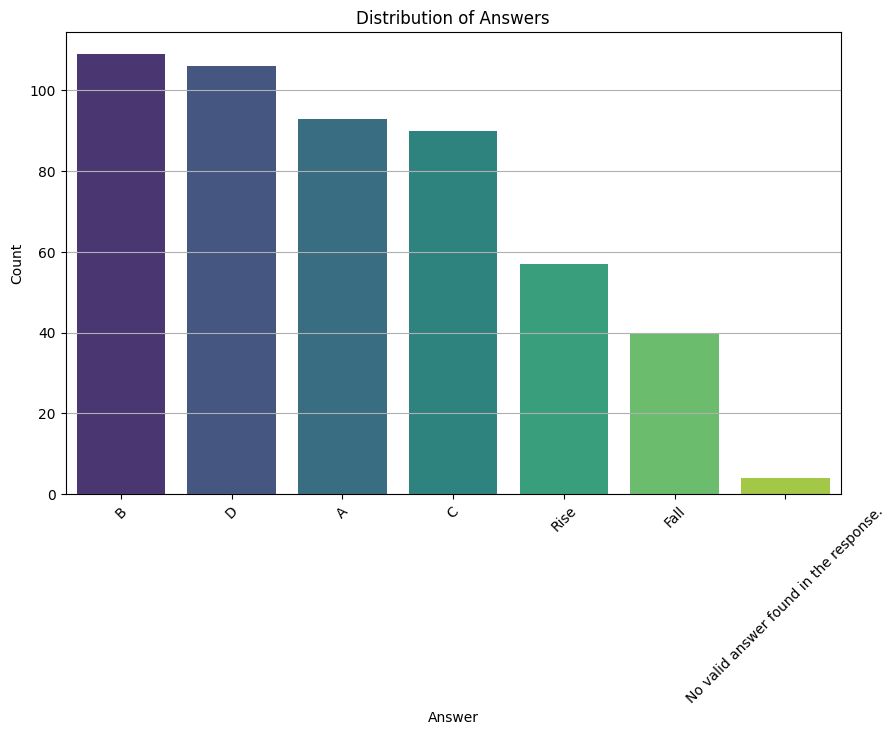

In [23]:
#plot the model has answers count A,B,C,D,E , Rise Fall
import matplotlib.pyplot as plt
import seaborn as sns
# Count answers
answer_counts = answer_df['answer'].value_counts()
# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=answer_counts.index, y=answer_counts.values, palette='viridis')
plt.title('Distribution of Answers')
plt.xlabel('Answer')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [24]:
# Save results to CSV
output_path = "/project/ai901501-ai0001/menth/submissions/"
file_name = "thalle_0.1_7b_fa_1.csv"
answer_df.to_csv(f"{output_path}{file_name}", index=False)
print(f"Results saved to {output_path}{file_name}")


Results saved to /project/ai901501-ai0001/menth/submissions/thalle_0.1_7b_fa_1.csv


In [33]:
query_id = "ed0074a8-aa7c-4499-8356-4720a17eb6fb"
pd.set_option('display.max_colwidth', None)
query_row = questions[questions['id'] == query_id]["query"]
print(query_row.to_string(index=False))



วิเคราะห์ข้อมูลและทวีตต่างๆ เพื่อพิจารณาว่าราคาปิดของ $gild จะปรับตัวขึ้นหรือลงในวันที่ 30 พฤศจิกายน 2017 โปรดระบุว่าขึ้นหรือลง  \nบริบท: วันที่, เปิด, สูง, ต่ำ, ปิด, ปิดปรับ, เพิ่ม 5%, เพิ่ม 10%, เพิ่ม 15%, เพิ่ม 20%, เพิ่ม 25%, เพิ่ม 30  \n2017-11-15, -1.6, 0.4, -1.8, 0.9, 0.9, 1.0, 1.5, 3.0, 5.3, 6.7, 8.1  \n2017-11-16, -0.9, 0.3, -1.6, 0.8, 0.8, -0.0, 0.4, 1.6, 3.8, 5.3, 6.7  \n2017-11-17, -0.2, 0.2, -0.4, 0.0, 0.0, -0.4, 0.2, 1.2, 3.1, 4.8, 6.2  \n2017-11-20, 0.4, 0.7, -0.8, -0.4, -0.4, -0.2, 0.6, 1.2, 3.0, 4.8, 6.2  \n2017-11-21, -0.6, 0.5, -1.0, 0.5, 0.5, -0.3, 0.0, 0.5, 2.0, 3.8, 5.1  \n2017-11-22, -0.5, 0.4, -0.6, 0.4, 0.4, -0.5, -0.5, -0.1, 1.0, 3.0, 4.2  \n2017-11-24, 0.4, 0.6, -0.3, -0.5, -0.5, 0.0, -0.0, 0.2, 1.2, 3.0, 4.4  \n2017-11-27, 1.1, 1.3, -0.3, -1.0, -1.0, 0.9, 0.7, 1.1, 1.9, 3.5, 5.0  \n2017-11-28, -0.6, 0.1, -1.6, 1.2, 1.2, -0.2, -0.5, -0.1, 0.4, 1.9, 3.4  \n2017-11-29, -1.1, 0.7, -1.5, 1.5, 1.5, -1.4, -1.7, -1.5, -1.2, 0.0, 1.6  \n\n2017-11-15: อย่าพลาดโอกาสซื้